In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_json('Data/denoised_processed_train.json')
test = pd.read_json('Data/denoised_processed_test.json')

In [4]:
train.sort_index(inplace=True)
test.sort_index(inplace=True)

In [5]:
print(train.head(3), train.shape)
print(test.head(3), test.shape)

                                          band_mixed  inc_angle  is_iceberg
0  [[[55, 60, 48], [56, 57, 48], [53, 54, 48], [5...    43.9239           0
1  [[[102, 58, 48], [97, 66, 48], [97, 68, 48], [...    38.1562           0
2  [[[68, 72, 48], [68, 73, 48], [67, 77, 48], [7...    45.2859           1 (1604, 3)
                                          band_mixed  inc_angle  is_iceberg
0  [[[91, 77, 48], [92, 78, 48], [88, 74, 48], [8...  34.966400           0
1  [[[64, 71, 48], [64, 71, 47], [64, 71, 47], [6...  32.615072           0
2  [[[95, 101, 48], [94, 101, 48], [91, 100, 48],...  37.505433           0 (8424, 3)


In [6]:
all_df = pd.concat([train, test])
print(all_df.shape)

(10028, 3)


In [7]:
all_df.reset_index(drop=True, inplace=True)

In [8]:
print(all_df.head(3), all_df.shape)

                                          band_mixed  inc_angle  is_iceberg
0  [[[55, 60, 48], [56, 57, 48], [53, 54, 48], [5...    43.9239           0
1  [[[102, 58, 48], [97, 66, 48], [97, 68, 48], [...    38.1562           0
2  [[[68, 72, 48], [68, 73, 48], [67, 77, 48], [7...    45.2859           1 (10028, 3)


In [85]:
from skimage import data, exposure, img_as_float
from skimage import filters

In [88]:
def rescale(img, use_global=False):
    if use_global is True:
        img_min = img[:,:,:].min()
        img_max = img[:,:,:].max()
    
    for i in range(2):
        if use_global is False:
            img_min = img[:,:,i].min()
            img_max = img[:,:,i].max()
        img[:,:,i] = (img[:,:,i] - img_min) / (img_max - img_min)
    
    img[:,:,2] = np.zeros((img.shape[0], img.shape[1]))
    #img[:,:,2] = (img[:,:,1] - img[:,:,0])
    #img_min = img[:,:,2].min()
    #img_max = img[:,:,2].max()  
    #img[:,:,2] = (img[:,:,2] - img_min) / (img_max - img_min)
    
    return img

In [97]:
def get_edge(img):
    img[:,:,2] = np.array(filters.sobel(img[:,:,0]))
    return img

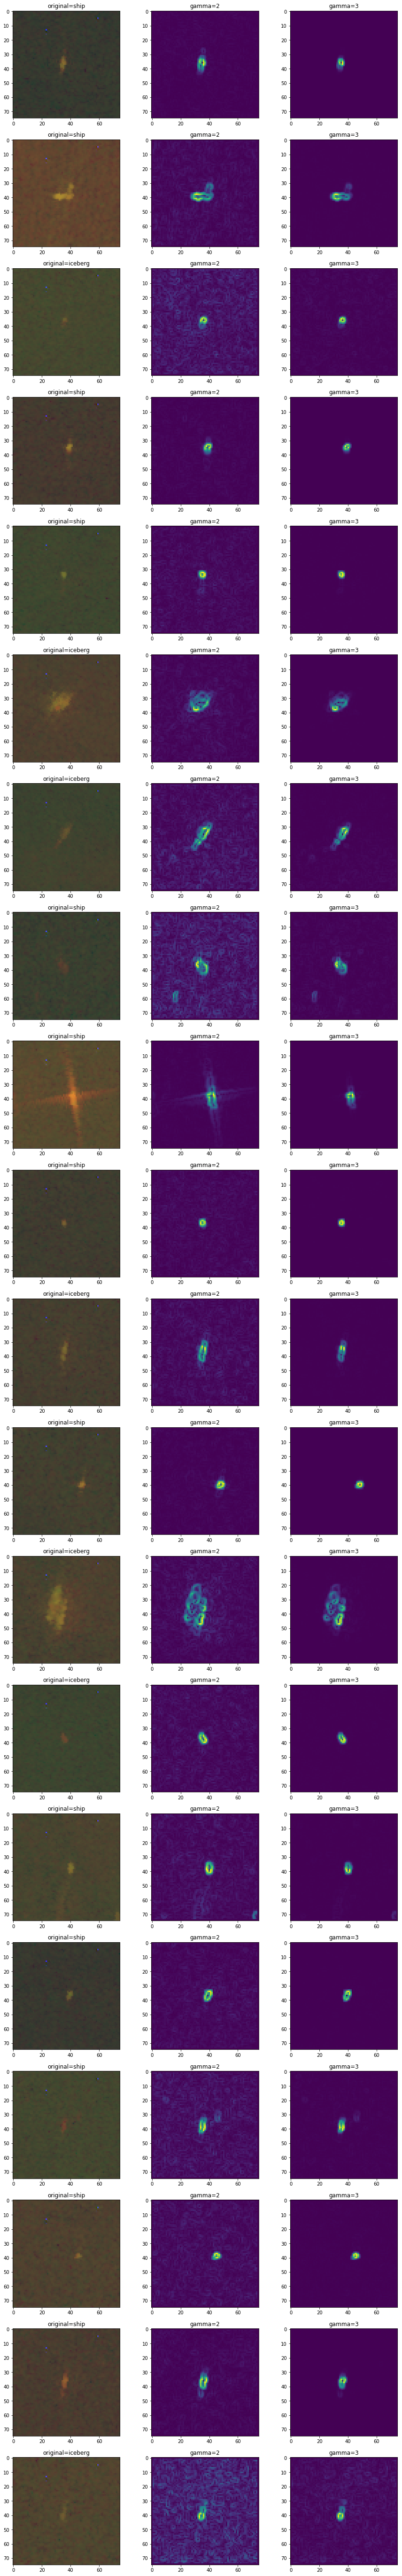

In [106]:
fig = plt.figure(1,figsize=(15,100))
for i in range(20):
    
    if all_df.loc[i, 'is_iceberg'] == 1:
        title = 'iceberg'
    else:
        title = 'ship'
    
    img = np.array(all_df.loc[i, 'band_mixed']).reshape((75,75,3))
    axes = [fig.add_subplot(20,3,3*i+a) for a in range(1,4)]
    
    img = img_as_float(img.astype(np.uint8))
    #img = rescale(img)
    #print('img old', img[:,:,0], 'min\max:', img[:,:,0].min(), img[:,:,0].max())
    
    img_2 = rescale(exposure.adjust_gamma(img, 2), True)
    img_2 = rescale(exposure.adjust_gamma(img_2, 2), False)
    img_2 = get_edge(img_2)
    #print('img 2', img_2[:,:,0], 'min\max:', img_2[:,:,0].min(), img_2[:,:,0].max())
    
    img_3 = rescale(exposure.adjust_gamma(img, 3), True)
    img_3 = rescale(exposure.adjust_gamma(img_3, 3), False)
    img_3 = get_edge(img_3)
    #print('img 3', img_3[:,:,0], 'min\max:', img_3[:,:,0].min(), img_3[:,:,0].max())
    
    axes[0].imshow(img)
    axes[0].set_title('original='+title)
    
    axes[1].imshow(img_2[:,:,2])
    axes[1].set_title('gamma=2')
    
    axes[2].imshow(img_3[:,:,2])
    axes[2].set_title('gamma=3')

In [107]:
for i in range(all_df.shape[0]):
    img = np.array(all_df.ix[i, 'band_mixed']).reshape((75,75,3))
    img = img_as_float(img.astype(np.uint8))
    
    img_2 = rescale(exposure.adjust_gamma(img, 2), True)
    img_2 = rescale(exposure.adjust_gamma(img_2, 2), False)
    img_2 = get_edge(img_2)
    
    img_2 *= 255.0
    img_2 = img_2.astype(np.uint8)
    
    all_df.set_value(i, 'band_mixed', img_2)
    print("\r{:.2f}% finished                 ".format((i+1)/all_df.shape[0]*100.), end="")

C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


100.00% finished                 

In [108]:
processed_train = all_df.iloc[:train.shape[0],]
processed_train['is_iceberg'] = train['is_iceberg']
processed_test = all_df.iloc[train.shape[0]:,]
processed_test['is_iceberg'] = np.zeros((test.shape[0],))

processed_train.reset_index(drop=True, inplace=True)
processed_test.reset_index(drop=True, inplace=True)

processed_train.to_json('Data/add_contrast_edge_processed_train.json')
processed_test.to_json('Data/add_contrast_edge_processed_test.json')

C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\khyeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


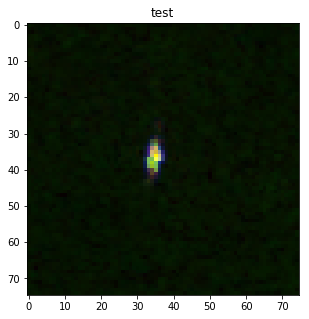

In [109]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(np.array(processed_train['band_mixed'][0]))
ax.set_title('test')